In [2]:
from protrend.utils import NeoDatabase, Settings

neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [3]:
import pandas as pd

dfs = []
labels = ['Effector',
          'Evidence',
          'Gene',
          'Operon',
          'Organism',
          'Pathway',
          'Publication',
          'Regulator',
          'RegulatoryFamily',
          'RegulatoryInteraction',
          'TFBS']
for label in labels:
    res = neo_db.db.cypher_query(f"match(s:Source)-[]-(t:{label}) return s.name, count(distinct(t.protrend_id))")
    df = pd.DataFrame(res[0], columns=['Source', 'Objects'])
    dfs.append(df)

In [4]:
df = pd.concat(dfs, keys=labels).reset_index(drop=False)
df = df.drop(columns=['level_1'])
df

,level_0,Source,Objects
0,Effector,regprecise,282
1,Effector,bsub_faria_et_al_2017,140
2,Effector,regulondb,67
3,Gene,collectf,1973
4,Gene,regprecise,88907
5,Gene,abasy,8178
6,Gene,coryneregnet,3854
7,Gene,bsub_faria_et_al_2017,1844
8,Gene,ecol_fang_et_al_2017,2190
9,Gene,mtub_turkarslan_et_al_2015,774


In [10]:
data = pd.pivot_table(df, values='Objects', index=['level_0'], columns=['Source'])
data = data.fillna(0)
data['Literature'] = data['bsub_faria_et_al_2017'] + data['ecol_fang_et_al_2017'] + data['mtub_turkarslan_et_al_2015']
data = data.drop(columns=['bsub_faria_et_al_2017', 'ecol_fang_et_al_2017', 'mtub_turkarslan_et_al_2015'])
data['total'] = data.sum(axis=1)
data = data.div(data.total, axis=0) * 100
data = data.rename(index={'RegulatoryFamily': 'R.Fam', 'RegulatoryInteraction': 'Interaction'})
data.index.name = 'Entity'
data.columns = ['Abasy', 'CollecTF', 'CoryneRegNet', 'DBTBS', 'ODB', 'RegPrecise', 'RegulonDB', 'Literature', 'Total']
data = data.drop(columns=['Total'])
data

,Abasy,CollecTF,CoryneRegNet,DBTBS,ODB,RegPrecise,RegulonDB,Literature
Entity,,,,,,,,
Effector,0.000000,0.000000,0.000000,0.000000,0.000000,57.668712,13.701431,28.629857
Gene,6.569888,1.585032,3.096154,0.535039,9.711834,71.424440,3.215052,3.862561
Operon,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
Organism,0.894188,15.648286,0.596125,0.149031,9.836066,72.280179,0.149031,0.447094
Pathway,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
Regulator,4.079101,1.598074,3.889375,0.795388,0.000000,84.384121,1.401051,3.852890
R.Fam,0.000000,0.000000,0.000000,1.123596,0.000000,70.786517,28.089888,0.000000
Interaction,5.570858,1.247369,4.428257,0.572038,0.000000,76.651681,5.599386,5.930411
TFBS,0.000000,2.550130,5.966981,1.304812,0.000000,83.129386,7.048690,0.000000


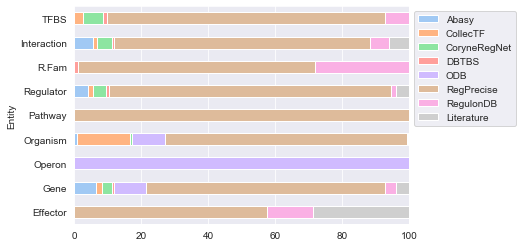

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
data.plot.barh(stacked=True, color=sns.color_palette('pastel').as_hex())

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.xlim(0, 100)

plt.savefig("source_report.png", bbox_inches="tight", dpi=150)
plt.show()

In [21]:
from protrend.utils import NeoDatabase, Settings
neo_db = NeoDatabase(user_name=Settings.db_user_name, password=Settings.db_password,
                     ip=Settings.db_ip, port=Settings.db_port)
neo_db.connect()

In [86]:
import pandas as pd

dfs = []
labels = ['Effector',
          'Gene',
          'Organism',
          'Regulator',
          'RegulatoryFamily',
          'RegulatoryInteraction',
          'TFBS']
for label in labels:
    res = neo_db.db.cypher_query(f"match(s:Source)-[]-(t:{label}) return t.protrend_id, count(distinct(s.protrend_id))")
    df = pd.DataFrame(res[0], columns=['Object', 'Sources'])
    df = df['Sources'].value_counts()
    dfs.append(df)

In [87]:
df = pd.concat(dfs, keys=labels)
df = df.reset_index(drop=False)
df = df.rename(columns={'level_0': 'Entity', 'level_1': 'Source out-Degree (Kout)', 'Sources': 'Objects'})
df

,Entity,Source out-Degree (Kout),Objects
0,Effector,1,334
1,Effector,2,61
2,Effector,3,11
3,Gene,1,84465
4,Gene,2,10242
5,Gene,3,2293
6,Gene,5,904
7,Gene,4,805
8,Gene,6,747
9,Gene,7,61


c:\users\bisbii\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


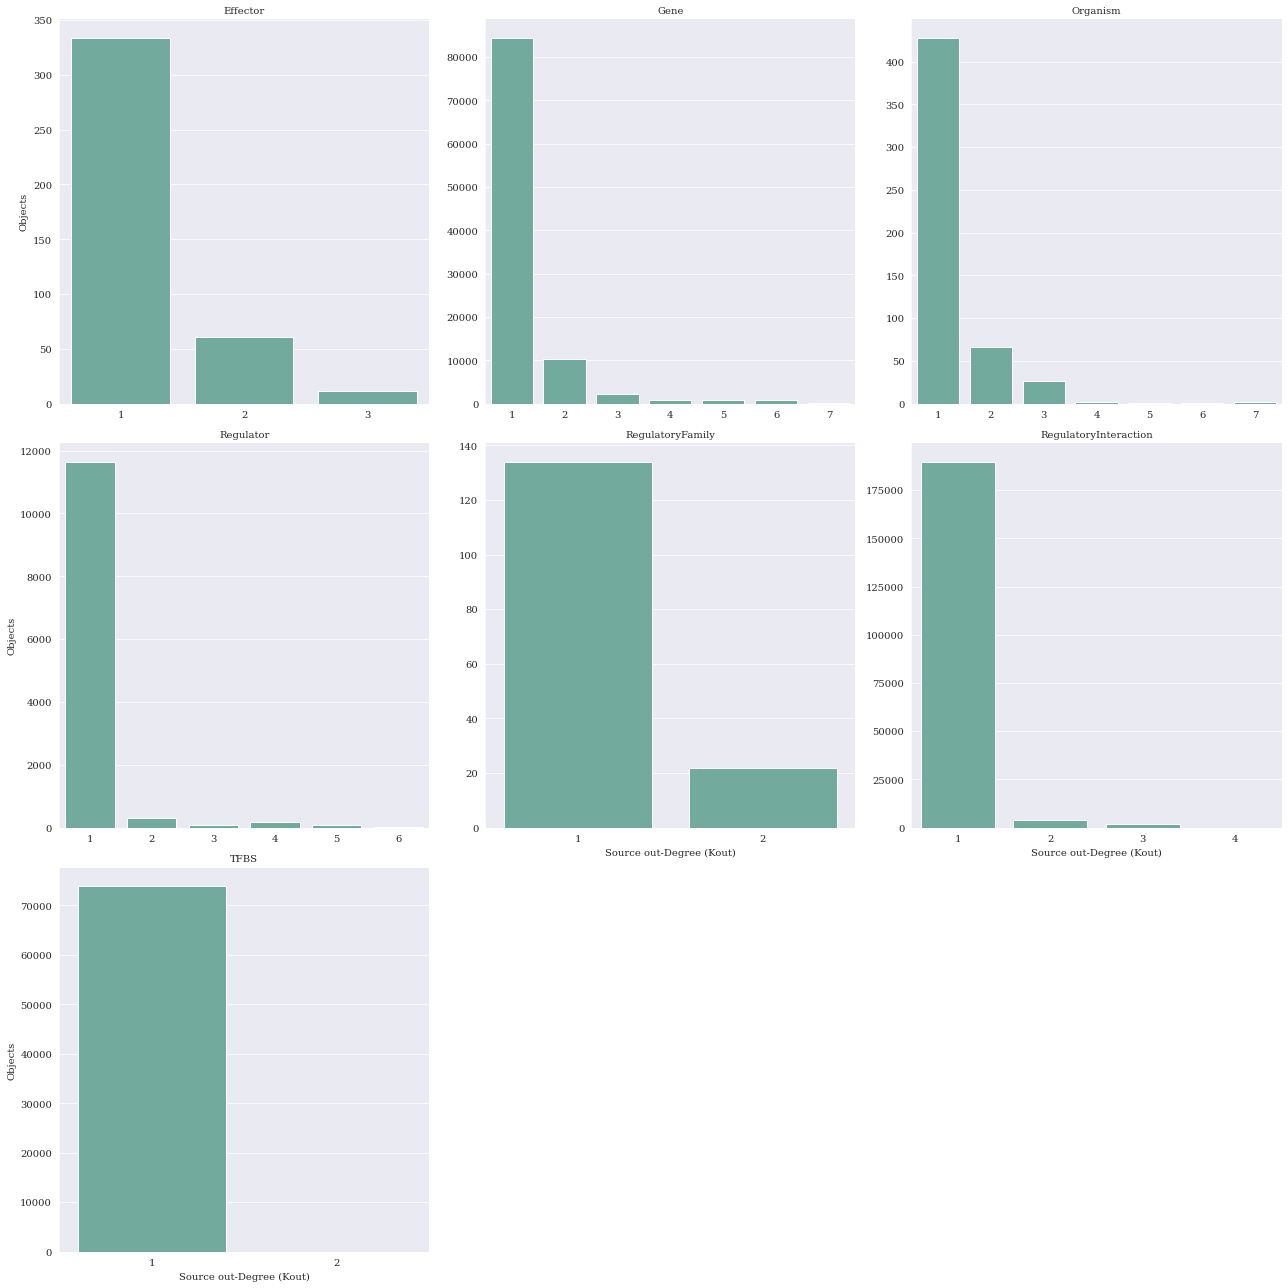

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df,
                  col="Entity",
                  col_wrap=3,
                  palette="Set3",
                  sharex=False,
                  sharey=False,
                  height=6)

g.map(sns.barplot,
      "Source out-Degree (Kout)",
      "Objects",
      color='#69b3a2')

g.set_titles("{col_name}")

plt.savefig("source_degree.png", bbox_inches="tight", dpi=150)
plt.show()

In [2]:
import pandas as pd

has_reg_precise = []
labels = ['Effector',
          'Gene',
          'Organism',
          'Regulator',
          'RegulatoryFamily',
          'RegulatoryInteraction',
          'TFBS']
for label in labels:
    res = neo_db.db.cypher_query(f"match(s:Source)-[]-(t:{label}) return t.protrend_id, s.name")
    df = pd.DataFrame(res[0], columns=['Object', 'Source'])
    has_reg_precise.append(df)

has_reg_precise

NameError: name 'neo_db' is not defined

In [1]:
reg_df = pd.concat(has_reg_precise, keys=labels)
reg_df = reg_df.drop_duplicates(subset=['Object', 'Source'])
reg_df

NameError: name 'pd' is not defined

In [ ]:
for label in labels:
    efc = reg_df.loc[label]
    efc = efc.groupby(['Object'])['Source'].apply(lambda x: list(x))
    print(label,
          efc.apply(lambda x: len(x) > 1).sum(),
          efc.apply(lambda x: len(x) > 1 and 'regprecise' in x).sum())